In [ ]:
#| default_exp vision.core

In [ ]:
#| export
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *

# Display of Multi-spectral images

A multi-spectral image consists of `n` channels of spectral data, some of which may correspond to the `R`, `G`, `B` channels of visible light. For example, the Sentinel-2 satellite image data, which is the initial use case for this library, consists of 13 channels, including the 3 `RGB` channels.

In [ ]:
#| export
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import display, HTML
from PIL import Image

import torch
import fastai
from fastai.vision.all import *

The display support is provided by `TensorImageMS` a subclass of the FastAI `TensorImage` class. It encapsulates tensors with `n` ordered (indexed) channels of spectral data.

In [ ]:
#| export
class TensorImageMS(TensorImage):
    pass

We create a simple factory for the class which takes the tensor of ordered channels as input. The parameters `bands` and `brgtX` will be introduced shortly.

In [ ]:
#| export
def create_TensorImageMS(t: Tensor, bands: list(tuple(int))=[], brgtX: list(list(float))=[]) -> TensorImageMS:
    return TensorImageMS(t, bands=bands, brgtX=brgtX)

In [ ]:
t = create_TensorImageMS([[1.,2.],[.3,.4],[5.,6.]])

test_eq(t, TensorImageMS([[1.,2.],[.3,.4],[5.,6.]]))
test_eq(t.bands,[])
test_eq(t.brgtX,[])

## Multiple images - one for each set of channels

Our approach is to display multiple images for each multi-spectral image. We can either present each channel as a single "monochrome" image, or more compactly, sets of 3 channels as one "false color" image (or as a true color image when we display the actual `RGB` channels).

This is done by providing a tuple of indices corresponding to the required channels. In practice, the tuple will either be of length 3 (false color) or 1 (monochrome). A list of these "channel tuples" is in the `bands` attribute.

The number of images in the visualization can be calculated from the list.

In [ ]:
#| export
@patch
def num_images(self: TensorImageMS) -> int:
    return len(self.bands)

In [ ]:
test_eq(t.num_images(),0)

Each individual image in the visualization is represented by a "filtered" tensor that represents the selected band(s). The following method does the selection.

In [ ]:
#| export
@patch
def _select_bands(self: TensorImageMS, bands: tuple[int]) -> TensorImageMS:
    assert len(bands) <= 3
    return torch.index_select(self, 0, torch.IntTensor(bands))

In [ ]:
t3 = t._select_bands((1,0,2))

test_eq(t3,TensorImageMS([[.3, .4],[1., 2.],[5.,6.]]))
test_eq(t3.bands,t.bands)
test_eq(t3.brgtX,t.brgtX)

t1 = t._select_bands((1,))
test_eq(t1,TensorImageMS([[.3, .4]]))

## Image Brightening

Another practical problem that needs to be addressed when dealing with normalized Sentinel 2 images is that typical pixel values are very "dark" when rendered graphically.

It is helpful to artificially brighten normalized tensors, using multipliers (that can vary according to the band). These multipliers lists are referenced by the `brgtX` attribute of our class. 

In [ ]:
#| export
@patch
def _brighten(self: TensorImageMS, brgtX: list[float]) -> TensorImageMS:
    assert self.shape[0] == len(brgtX)
    brdcsts = [None] * max(0, len(self.shape) - 1)
    multX = reduce(lambda mX, _: mX.unsqueeze(-1), brdcsts, Tensor(brgtX))
    return torch.clamp(self * multX, 0, 1)

Test calculation

In [ ]:
t1b2 = t1._brighten([2.])
test_eq(t1b2, TensorImageMS([[0.6, 0.8]]))

Use a multiplier of `1.0` when brightening is not called for.

In [ ]:
t1b1 = t1._brighten([1.])
test_eq(t1b1, t1)

## Display on grid

The brightened images are then displayed in the contexts that represent a `matplotlib` grid of images.

In [ ]:
#| export
@patch
def _show_tiles(self: TensorImageMS, ctxs: list, **kwargs) -> list:
    assert ctxs is not None
    ims: TensorImageMS = [self._select_bands(b)._brighten(m) for b, m in zip(self.bands, self.brgtX)]
    return [show_image(im, ax=ax) for im, ax in zip(ims, ctxs)]

The grid consists of rows, one for each MS image. Each row consists of all the individual images (one per column) corresponding to channel sets.

In [ ]:
#| export
@patch
def _get_grid(self: TensorImageMS, nrows: int, **kwargs) -> list:
    ncols = self.num_images()
    ncells = nrows * ncols
    return get_grid(ncells, nrows, ncols, **kwargs)

This is all put together to display the final image(s).

In [ ]:
#| export
@patch
def show(self: TensorImageMS, ctxs=None, **kwargs) -> list:
    ctxs = self._get_grid(1, **kwargs) if ctxs is None else ctxs
    return self._show_tiles(ctxs=ctxs, **kwargs)

## Example

We use the MS file io functionality defined [here](00_vision.io.ipynb) to load a multi spectral image tensor.

In [ ]:
from fastai_geospatial.vision.io import *

def load_tensor(tile_num: int):
    bands=[(2,1,0),(3,)]
    brgtX=[[1.,1.,1.],[1.]]
    files=[get_input(tile_img_name(c, tile_num)) for c in ["B02","B03","B04","B8A"]]
    t=read_multichan_files_as_tensor(files)
    return TensorImageMS(t,bands=bands,brgtX=brgtX)

[<AxesSubplot: >, <AxesSubplot: >]

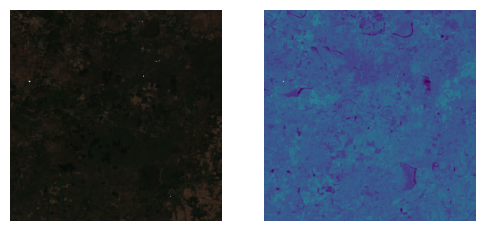

In [ ]:
msimg=load_tensor(60)
msimg.show()

## Animating multiple images

Another possibility for display of the individual images of channel tuples is to create an animation that cycles through the images, rather than laying them out as a row of images.

In [ ]:
#| export
@patch
def _show_animation(self: TensorImageMS):
    fig, ax = plt.subplots()
    ax.axis("off")
    ims = [
        [ax.imshow(self._select_bands(b)._brighten(m).permute(1, 2, 0), animated=True)]
        for b, m in zip(self.bands, self.brgtX)
    ]
    anim = animation.ArtistAnimation(fig, ims, interval=1000, blit=True)
    plt.close()
    display(HTML(anim.to_html5_video()))

In [ ]:
msimg._show_animation()

This reduces the amount of visual space taken up by the image, and also makes it easier to see how an individual pixel/area changes "color" according to the spectral channel.

However, since this creates an embedded HTML movie, it results in a large increase in the cell output size.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()